In [7]:
import spacy
import pandas as pd
import numpy as np
from spacy.lang.en import English
import en_core_web_lg
from  spacy.lang.en.stop_words import STOP_WORDS
from spacy.matcher import Matcher
from spacy.matcher import PhraseMatcher
import string
import re
import nltk
from nltk.stem.porter import *
from wordcloud import WordCloud
import seaborn as sns

ModuleNotFoundError: No module named 'en_core_web_lg'

In [2]:
import matplotlib.pyplot as plt 

%matplotlib inline

In [2]:
stopwords = list(STOP_WORDS)

In [3]:
punctuations = string.punctuation.replace("#", "")
parser = English()

In [4]:
nlp = en_core_web_sm.load()
print(stopwords)

['n‘t', 'will', 'never', 'otherwise', 'thereupon', 'an', 'since', "'d", "n't", 'name', 'ourselves', '‘re', '’ve', 'ever', 'made', 'do', 'after', 'am', 'becoming', 'thence', 'throughout', 'else', 'over', 'whole', 'other', 'between', 'alone', 'anyhow', 'mostly', 'or', 'whereas', 'any', 'bottom', 'both', 'whence', 'such', 'though', 'several', 'nevertheless', 'yourselves', 'on', 'much', 'afterwards', 'did', 'former', 'part', 'somehow', 'twenty', 'hereupon', 'please', 'yourself', 'around', 'get', 'should', '’m', 'through', 'himself', "'ll", 'his', 'a', 'above', 'most', 'him', 'just', 're', 'because', 'toward', 'towards', '‘ll', 'no', 'yours', 'its', 'eight', 'may', 'but', 'herself', 'my', 'some', 'then', 'being', 'none', 'what', 'them', 'hers', 'you', 'why', 'least', 'was', 'rather', 'put', 'were', 'twelve', 'we', 'themselves', 'latter', 'whither', 'he', 'already', 'your', 'sometime', 'only', 'becomes', 'here', 'make', 'doing', 'into', 'meanwhile', 'across', 'two', 'enough', 'if', 'thereby'

In [5]:
# Stemming
stemmer = PorterStemmer()

In [6]:
print(punctuations)

!"$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [7]:
def spacy_tokenizer(sentence):
    tokens = parser(sentence)
    # Lower case all words and strip white spaces
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    # Remove all stop words and punctuations
    tokens = [word for word in tokens if word not in stopwords and word not in punctuations]
    return tokens

In [8]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [9]:
def tokenize_tweet(tweet):
    tokenized_tweet = [t.text for t in nlp(tweet)]
    
    tokenized_tweet = [stemmer.stem(t) for t in tokenized_tweet]
    
    tokenized_tweet = ' '.join(tokenized_tweet)
    
    return tokenized_tweet

In [10]:
phraseTerms = [
        u"windows 10",
        u"big data",
        u"data analytics"
    ]

In [72]:
def clean_sentence(sentence):
    doc = nlp(sentence)
    
    # Phrase matchers
    phraseMatcher = PhraseMatcher(nlp.vocab, attr="LOWER")
    phrasePatterns = [nlp.make_doc(text) for text in phraseTerms]
    
    phraseMatcher.add("Names", None, *phrasePatterns)
    
    for match_id, start, end in phraseMatcher(doc):
        span = doc[start:end]
        sentence = sentence.replace(span.text, ''.join(token.text for token in span))
    
    # Token matchers
    matcher = Matcher(nlp.vocab)
    
    # Create matcher to detect urls
    pattern = [{ "LIKE_URL": True }]
    matcher.add("UrlDetection", None, pattern)
    
    # Create matcher to detect ...
    pattern = [{ "TEXT": "..." }]
    matcher.add("MoreDotsDetection", None, pattern)
    
    matches = matcher(doc)
    
    for match_id, start, end in matches:
        string_id = nlp.vocab.strings[match_id]
        span = doc[start:end]
        sentence = sentence.replace(span.text, '')
    
    # Tokenize sentence and join
    sentence = ' '.join(str(token) for token in spacy_tokenizer(sentence))
    
    # Remove twitter handles
    sentence = remove_pattern(sentence, "@[\w]*")
    
    sentence = '#'.join([phrase for phrase in [e[1:] for e in (' ' + sentence).split("#")]])

    # remove words with length less than 3 and not #
    sentence = ' '.join([word for word in sentence.split() if word[0] == '#' or len(word)>3])
    
    return sentence

clean_sentence("The latest Logan's DX Daily #AD (Cloud, AI/ML, Analytics & IoT)! https://t.co/Ac3cKz73Gx Thanks to @JD_Corporate... https://t.co/OOyzLIPxA2")

'late logan daily #ad cloud analytics thanks'

In [73]:
df = pd.read_csv("data/flair_labeled_sentiments_long.csv", names=['feedback', 'text'])
df.head()

,feedback,text
0,__label__Negative,Big Data Is Dead. Long Live Big Data AI #Machi...
1,__label__Negative,Data Analytics 'Performance Gap' Destroying Cu...
2,__label__Negative,Big Data Is Dead. Long Live Big Data AI. - htt...
3,__label__Negative,Big Data and the Problem of Bias in Higher Edu...
4,__label__Positive,Using Twitter for big data analytics to analyz...


In [74]:
df['feedback'] = df['feedback'].replace('__label__Negative', 0)
df['feedback'] = df['feedback'].replace('__label__Positive', 1)

In [75]:
df.head()

,feedback,text
0,0,Big Data Is Dead. Long Live Big Data AI #Machi...
1,0,Data Analytics 'Performance Gap' Destroying Cu...
2,0,Big Data Is Dead. Long Live Big Data AI. - htt...
3,0,Big Data and the Problem of Bias in Higher Edu...
4,1,Using Twitter for big data analytics to analyz...


In [76]:
df['clean_text'] = np.vectorize(clean_sentence)(df['text'])

In [77]:
df.head()

,feedback,text,clean_text
0,0,Big Data Is Dead. Long Live Big Data AI #Machi...,bigdata dead long live bigdata #machinelearnin...
1,0,Data Analytics 'Performance Gap' Destroying Cu...,dataanalytics performance destroying customer ...
2,0,Big Data Is Dead. Long Live Big Data AI. - htt...,bigdata dead long live bigdata #bigdata #dataa...
3,0,Big Data and the Problem of Bias in Higher Edu...,bigdata problem bias higher education #bigdata...
4,1,Using Twitter for big data analytics to analyz...,twitter bigdataanalytics analyze disaster #soc...


In [79]:
# Remove duplicates
df = df.drop_duplicates(subset=['clean_text'], keep='first')

In [80]:
df.head(10)

,feedback,text,clean_text
0,0,Big Data Is Dead. Long Live Big Data AI #Machi...,bigdata dead long live bigdata #machinelearnin...
1,0,Data Analytics 'Performance Gap' Destroying Cu...,dataanalytics performance destroying customer ...
2,0,Big Data Is Dead. Long Live Big Data AI. - htt...,bigdata dead long live bigdata #bigdata #dataa...
3,0,Big Data and the Problem of Bias in Higher Edu...,bigdata problem bias higher education #bigdata...
4,1,Using Twitter for big data analytics to analyz...,twitter bigdataanalytics analyze disaster #soc...
7,1,Azure Big Data Analytics Platform Databricksto...,azure bigdataanalytics platform databrickstoka...
8,1,DZone >> Automate or Die: A Dramatic State of ...,dzone automate dramatic state affairs 21st cen...
9,1,Big data in a nutshell https://t.co/HxdnUe7IQI...,bigdata nutshell overview bigdata #crm fraud d...
10,1,Tired of your current job? Check this out! => ...,tired current check bigdata application develo...
11,1,Big Data And The Problem Of Bias In Higher Edu...,bigdata problem bias higher education explosiv...


In [33]:
# # DON'T RUN THIS

# df['clean_text'] = df['clean_text'].apply(lambda x: tokenize_tweet(x))

# print(df['clean_text'].head())

In [34]:
# # DON'T RUN THIS
# # Common words in the tweets
# all_words = ' '.join([text for text in df['clean_text']])
# wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

# plt.figure(figsize=(10, 7))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()

In [35]:
# # DON'T RUN THIS
# # Positive words
# positive_words =' '.join([text for text in df['clean_text'][df['feedback'] == 1]])

# wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)
# plt.figure(figsize=(10, 7))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()

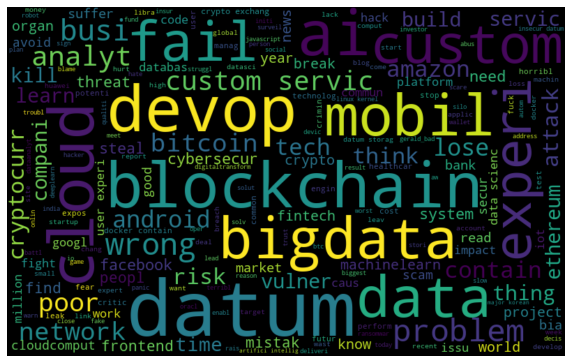

In [103]:
# # DON'T RUN THIS
# # Negative words
# negative_words = ' '.join([text for text in df['clean_text'][df['feedback'] == 0]])
# wordcloud = WordCloud(width=800, height=500,
# random_state=21, max_font_size=110).generate(negative_words)
# plt.figure(figsize=(10, 7))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.show()

In [104]:
# # DON'T RUN THIS
# # Function to collect hashtag
# def hashtag_extract(x):
#     hashtags = []
#     # Loop over the words in the tweet
#     for i in x:
#         i = '#'.join([phrase for phrase in [e[1:] for e in i.split("#")]])
#         tag = re.findall(r"#(\w+)", i)
#         hashtags.append(tag)

#     return hashtags

In [105]:
# # DON'T RUN THIS
# # Extracting hashtags from Positive Response
# HT_regular = hashtag_extract(df['clean_text'][df['feedback'] == 0])

# # Extracting hashtags from Negative Response
# HT_negative = hashtag_extract(df['clean_text'][df['feedback'] == 1])

# # Unnesting list
# HT_regular = sum(HT_regular,[])
# HT_negative = sum(HT_negative,[])

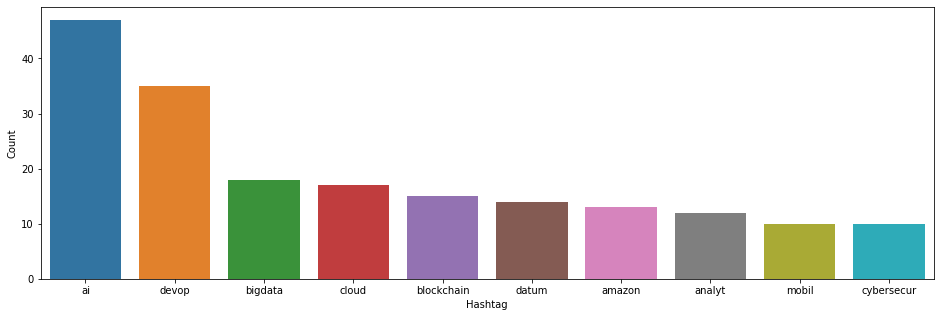

In [106]:
# # DON'T RUN THIS
# # Positive tweets
# a = nltk.FreqDist(HT_regular)
# d = pd.DataFrame({'Hashtag': list(a.keys()),
#                   'Count': list(a.values())})
# # selecting top 10 most frequent hashtags     
# d = d.nlargest(columns="Count", n = 10) 
# plt.figure(figsize=(16,5))
# ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
# ax.set(ylabel = 'Count')
# plt.show()

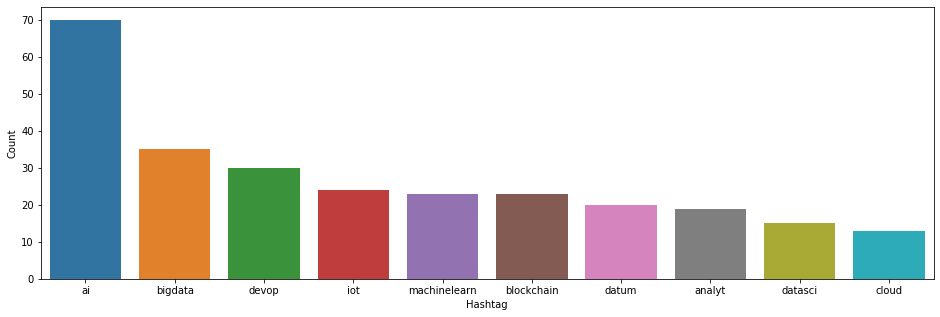

In [107]:
# # DON'T RUN THIS
# # Negative tweets
# a = nltk.FreqDist(HT_negative)
# d = pd.DataFrame({'Hashtag': list(a.keys()),
#                   'Count': list(a.values())})
# # selecting top 10 most frequent hashtags     
# d = d.nlargest(columns="Count", n = 10) 
# plt.figure(figsize=(16,5))
# ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
# ax.set(ylabel = 'Count')
# plt.show()

In [53]:
# from sklearn.feature_extraction.text import CountVectorizer

# bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# # bag-of-words feature matrix
# bow = bow_vectorizer.fit_transform(df['clean_text'])

In [32]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# # TF-IDF feature matrix
# tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

In [33]:
# bow.shape

(1892, 1000)

In [37]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score

# train_bow = bow[:1000,:]
# test_bow = bow[1000:,:]

# # splitting data into training and validation set
# xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, df['feedback'][0:1000], random_state=42, test_size=0.3)

# lreg = LogisticRegression()

# # Training the model
# lreg.fit(xtrain_bow, ytrain) 

# # Predicting on the validation set
# prediction = lreg.predict_proba(xvalid_bow)
# # If prediction is greater than or equal to 0.3 than 1 else 0
# prediction_int = prediction[:,1] >= 0.3
# prediction_int = prediction_int.astype(np.int)

# # Calculating f1 score
# f1_score(yvalid, prediction_int)

0.7281795511221945

In [38]:
# df_test = pd.read_csv("data/flair_labeled_sentiments_long.csv", names=['feedback', 'text'])

# df_test = df_test[10000:10892]
# print(df_test.shape)

# test_pred = lreg.predict_proba(test_bow)
# test_pred_int = test_pred[:,1] >= 0.3
# test_pred_int = test_pred_int.astype(np.int)
# print(len(test_pred_int))
# df_test['feedback'] = test_pred_int
# submission = df_test[['text', 'feedback']]
# submission.to_csv('sub_lreg_bow.csv', index=False) # Writing data to a CSV file

(892, 2)
892


In [39]:
# train_tfidf = tfidf[:1000,:]
# test_tfidf = tfidf[1000:,:]

# xtrain_tfidf = train_tfidf[ytrain.index]
# xvalid_tfidf = train_tfidf[yvalid.index]

# lreg.fit(xtrain_tfidf, ytrain)

# prediction = lreg.predict_proba(xvalid_tfidf)
# prediction_int = prediction[:,1] >= 0.3
# prediction_int = prediction_int.astype(np.int)

# f1_score(yvalid, prediction_int)

0.7264573991031391

In [81]:
import random
from pathlib import Path
import spacy
from spacy.util import minibatch, compounding

In [82]:
def main(model=None, output_dir=None, n_iter=20, n_texts=2000):
    if model is not None:
        # load existing spaCy model
        nlp = spacy.load(model)
        print("Loaded model '%s'" % model)
    else:
        # Create blank Language class
        nlp = spacy.load('en_core_web_sm')
        print("Created blank 'en' model")

    # Add the text classifier to the pipeline if it doesn't exist
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'textcat' not in nlp.pipe_names:
        textcat = nlp.create_pipe('textcat')
        nlp.add_pipe(textcat, last=True)
    # Otherwise, get it, so we can add labels to it
    else:
        textcat = nlp.get_pipe('textcat')

    # Add label to text classifier
    textcat.add_label('POSITIVE')
    textcat.add_label('NEGATIVE')

    (train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit=n_texts)
    print("Using {} examples ({} training, {} evaluation)"
          .format(n_texts, len(train_texts), len(dev_texts)))
    train_data = list(zip(train_texts,
                          [{'cats': cats} for cats in train_cats]))

    # Get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
    
    # Only train textcat by disabling other pipes
    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.begin_training()
        print("Training the model...")
        print('{:^5}\{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('No.', 'LOSS', 'P', 'R', 'F'))
        for i in range(n_iter):
            losses = {}
            # Batch up the examples using spaCy's minibatch
            batches = minibatch(train_data, size=compounding(4., 32., 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                           losses=losses)
            
            with textcat.model.use_params(optimizer.averages):
                # Evaluate on the dev data split off in load_data()
                scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
            print('{0}\t{1:.3f}\t{2:.3f}\t{3:.3f}\t{4:.3f}'  # print a simple table
                  .format(i, losses['textcat'], scores['textcat_p'],
                          scores['textcat_r'], scores['textcat_f']))

    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

In [83]:
def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}

In [84]:
df.shape

(19592, 3)

In [70]:
def load_data(limit=0, split=0.8):
    # Partition off part of the train data for evaluation
    cats = [{'POSITIVE': bool(y), 'NEGATIVE': not bool(y)} for y in df['feedback']]
    split = int(len(df['clean_text'].values) * split)
    return (df['clean_text'][:split], cats[:split]), (df['clean_text'][split:], cats[split:])

In [ ]:
main(model=None, output_dir="text_cnn_models/en_model", n_iter=20, n_texts=19592)

Created blank 'en' model
Using 19592 examples (15673 training, 3919 evaluation)
Training the model...
 No. \LOSS 	  P  	  R  	  F  
0	11.329	1.000	1.000	1.000
1	14.163	1.000	1.000	1.000
2	12.753	0.960	0.965	0.962
3	13.653	0.488	0.436	0.461
4	7.957	0.265	0.349	0.302
5	6.581	0.278	0.301	0.289
6	5.761	0.451	0.450	0.451
7	4.519	0.643	0.679	0.661
8	3.718	0.460	0.469	0.464


In [41]:
model = 'text_cnn_models/model'

nlp = spacy.load(model)

def predict_test(text):
    test_text = clean_sentence(text)
    doc = nlp(test_text)
    print(test_text, doc.cats)

In [42]:
predict_test("This is why I always hated working with #Windows. No, I was not missing it at all in my current job in #RedHat.... https://t.co/1gZlVbPwHH")

hate work  miss current job  .... {'POSITIVE': 0.8795822262763977}


In [43]:
predict_test("RT MakeUseOf: hate using it on your wireless ro... https://t.co/JLuKKhUC96")

rt makeuseof hate use wireless ro {'POSITIVE': 0.881860613822937}


In [44]:
predict_test("Dead End Job #Windows #Mac #Linux <Headup> ga, 2020Nian Pei Xin niYan Qi saremashita. https://t.co/d8Auyfps9F")

dead end job    headup ga 2020nian pei xin niyan qi saremashita {'POSITIVE': 0.023645827546715736}


In [45]:
predict_test("RT @OriginalFunko: Gears of War meets Funko is available for download now on iOS, Android and Windows 10 PC! Have you playe...")

rt  gears war meet funko available download ios android windows10 pc playe {'POSITIVE': 0.9556255340576172}


In [46]:
predict_test("Windows 10 update: #Microsoft could change this iconic feature and some fans aren't happy #operatingsystem...... https://t.co/wuquSEakzH")

windows10 update  change iconic feature fan happy  ...... {'POSITIVE': 0.003124868031591177}


In [47]:
predict_test("@vzverovich SuSE linux 6.1. I didn't understand anything about it and destroyed my Windows10 partition in the process.")

 suse linux 6.1 understand destroy windows10 partition process {'POSITIVE': 0.005483363289386034}


In [49]:
predict_test("freezing windows 10")

freeze windows10 {'POSITIVE': 0.029243461787700653}


In [50]:
predict_test("RT RedHatSupport: Choosing the right data storage is complicated. Learn more about block storage, file storage, and... https://t.co/zJOVbQh5sa")

rt redhatsupport choosing right datum storage complicate learn block storage file storage {'POSITIVE': 0.9828402996063232}


In [51]:
predict_test("@RedHat Red Hat = MAGA = A symbol of hate & racism. Bad branding. Unless your company is pro-Trump?")

 red hat maga symbol hate racism bad brand company pro trump {'POSITIVE': 0.0005993598606437445}


In [52]:
predict_test("@RedHat Such an unfortunate name.")

 unfortunate {'POSITIVE': 0.8864790797233582}


In [53]:
predict_test("#redhat keeps making up and/or spreading stupid buzzwords. ProdOps? Seriously? You're FullOfBullshitOps! https://t.co/ewpbSm2RY9")

 and/or spread stupid buzzword prodops seriously fullofbullshitops {'POSITIVE': 0.252778559923172}


In [54]:
predict_test("@RedHat Why would people buy a crappy hack of an OS when Red Hat exists!")

 people buy crappy hack os red hat exist {'POSITIVE': 0.5904809236526489}


In [55]:
predict_test("@RedHat Unfortunate name. When I hear Red Hat I think MAGA. Sorry")

 unfortunate hear red hat think maga sorry {'POSITIVE': 0.12254658341407776}


In [56]:
predict_test("This girl was scammed out of $1500 in Bitcoin due to @blockchain wallet poor customer service.... https://t.co/QfGhcHI6do")

girl scam 1500 bitcoin  wallet poor customer service .... {'POSITIVE': 0.0002595556143205613}


In [57]:
predict_test("$QNT has finally broke up from this mind numbing range.. If you are in $QNT.. I'm sorry you had to sit through tha... https://t.co/iF6hwH4Guf")

qnt finally break mind numb range .. qnt .. sorry sit tha {'POSITIVE': 0.013065618462860584}


In [58]:
predict_test("Daily Practice: coding a #Blockchain in Java, using TDD; adding difficulty to JSON Block encoding, simple!")

daily practice code  java use tdd add difficulty json block encode simple {'POSITIVE': 0.2295592874288559}


In [59]:
predict_test("No need to fight with thousands of other cruisers...this seat is YOURS https://t.co/pYKj4p5QAu #luxuryescapes... https://t.co/UXwqUlEu6d")

need fight thousand cruisersthis seat  {'POSITIVE': 0.9962440729141235}


In [60]:
predict_test("RT @IAM__Network: IAM Platform Curated Retweet: Will Blockchain kill banking as we know it? - The New Daily https://t.co/fyMo71t25c #women...")

rt  iam platform curated retweet blockchain kill bank know new daily  {'POSITIVE': 0.2646695077419281}


In [61]:
predict_test("holy fuck this is insane #COINBASE! I just received 2.68 #btc! Anyone can join, not much left!!! https://t.co/rt2z9osiVd")

holy fuck insane  receive 2.68  join leave {'POSITIVE': 0.03020145744085312}


In [62]:
predict_test("RT @BuucketHe4d: oh crap just deleted my entire blockchain there's no undo button wtf")

rt  oh crap delete entire blockchain undo button wtf {'POSITIVE': 4.539787187241018e-05}


In [63]:
predict_test("This @DrKateMarvel fairy tale is of and for our modern times and it is And no, blockchain is no the \"wolf\" sol... https://t.co/BYLu82O9jq")

 fairy tale modern time blockchain wolf sol {'POSITIVE': 0.9998832941055298}


In [64]:
predict_test("VEX BLOCK is now featured on @themerklehash as the first blockchain project that have developed the first world cry... https://t.co/PFiYMzf2Bt")

vex block feature  ﻿1 blockchain project develope ﻿1 world cry {'POSITIVE': 0.12938600778579712}


In [65]:
predict_test("Unfortunately, nowadays fake accounts are common cases. @Revain_org is trying to fight it with AI, blockchain and r... https://t.co/xicIgcpzc3")

unfortunately nowadays fake account common case  try fight ai blockchain r {'POSITIVE': 0.31474825739860535}


In [66]:
predict_test("Feel Lucky? Flw, Fav and Retweet to win Kojak's python-pinging Hormonal Throat Apocolypse #WIN https://t.co/kLwsmbVDUN")

feel lucky flw fav retweet win kojak python ping hormonal throat apocolypse  {'POSITIVE': 0.28433072566986084}


In [67]:
predict_test("Star Wars: The Rise of Skywalker -- Everything we know about 'Dark Side Rey' - CNET")

star wars rise skywalker -- know dark rey cnet {'POSITIVE': 0.0005546548636630177}


In [15]:
predict_test("RT @ScanComputers: #WIN an @AMD gaming PC feat Ryzen 7 3700X & @PowerColor Radeon RX 5700 XT!!! WORTH OVER PS1500!! @ScanComputers weekly #g...")

#win gaming feat ryzen 3700x radeon 5700 worth ps1500 weekly #g {'POSITIVE': 0.01959080807864666}


In [16]:
predict_test("RT @catexofficial: FREE ETHEREUM GIVEAWAY + OGOD AIRDROP We will pick 4 participants to win 0.25 #ETH each To qualify for free ETH you m...")

free ethereum giveaway ogod airdrop pick participant 0.25 #eth qualify free {'POSITIVE': 0.013028740882873535}


In [19]:
predict_test("Here's how to create a personal growth plan that really works. https://t.co/igULDQHRob #tech #trending #Business... https://t.co/lL91lPOwGE")

create personal growth plan work {'POSITIVE': 0.0050103794783353806}


In [20]:
predict_test("RT @bruntmor: Enter to #win Bruntmor's Enameled 12-Inch Deep Saute Pan in Any Color! #follow #retweet Winner Announced September 5th, USA O...")

enter #win bruntmor enameled 12-inch deep saute color #follow #retweet winner announced september {'POSITIVE': 0.0007138650398701429}


In [78]:
predict_test("Want to win 50000 DOGECOINS Free? Register with only 2 clicks! https://t.co/CgpuxohQDe - #crypto #bitcoin #giveaway... https://t.co/ieTGdXvI2D")

want 50000 dogecoins free register click #crypto #bitcoin #giveaway {'POSITIVE': 0.0003056121931876987}
